In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
import splitfolders

In [6]:
splitfolders.ratio(r"C:\Users\ajayk\Desktop\InnoProjects\Fabric_defect_detection_system\testing_dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 412 files [00:00, 517.12 files/s]


In [7]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [8]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [9]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
3 folder and 0 images in output\test
0 folder and 10 images in output\test\hole
0 folder and 7 images in output\test\horizontal
0 folder and 5 images in output\test\verticle
3 folder and 0 images in output\train
0 folder and 138 images in output\train\hole
0 folder and 102 images in output\train\horizontal
0 folder and 69 images in output\train\verticle
3 folder and 0 images in output\val
0 folder and 36 images in output\val\hole
0 folder and 27 images in output\val\horizontal
0 folder and 18 images in output\val\verticle


In [4]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (360, 640)


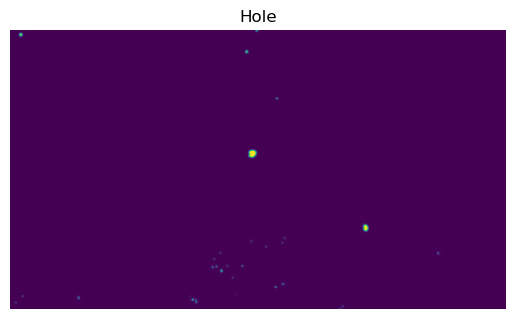

In [5]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Hole')

Image Shape : (360, 640)


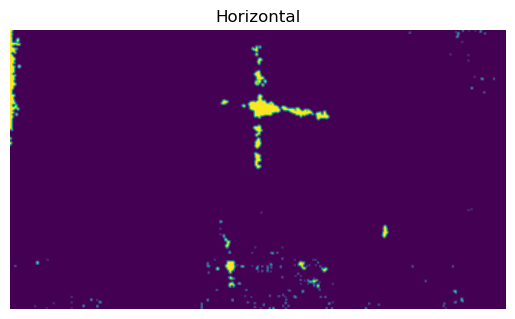

In [9]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Horizontal')

Image Shape : (360, 640, 3)


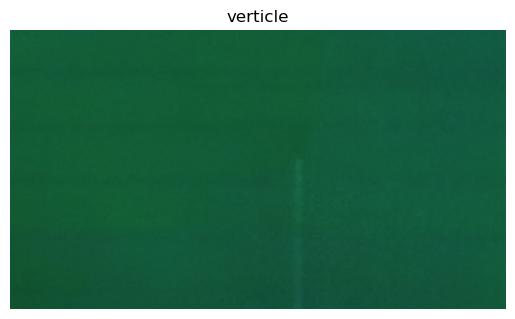

In [8]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='verticle')

In [14]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [15]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 309 images belonging to 3 classes.
Found 81 images belonging to 3 classes.
Found 22 images belonging to 3 classes.


In [16]:
train_data.class_indices

{'hole': 0, 'horizontal': 1, 'verticle': 2}

In [17]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [18]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (309,)
val_y.shape:  (81,)
test_y.shape:  (22,)


In [19]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [20]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(3)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [22]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=100, validation_data=valid_data)

Epoch 1/100


C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.2114 - loss: 1.2725 - val_accuracy: 0.4444 - val_loss: 1.0737
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.4622 - loss: 1.0892 - val_accuracy: 0.6173 - val_loss: 0.9786
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.5583 - loss: 0.9945 - val_accuracy: 0.6296 - val_loss: 0.8929
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.6115 - loss: 0.9285 - val_accuracy: 0.6914 - val_loss: 0.8252
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.6335 - loss: 0.8755 - val_accuracy: 0.6914 - val_loss: 0.7834
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.6283 - loss: 0.8621 - val_accuracy: 0.6914 - val_loss: 0.7434
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.7090 - loss: 0.7747 - val_accuracy: 0.7037 - val_loss: 0.7114
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.6690 - loss: 0.7563 - val_accuracy: 0.7284 - val_loss: 0.6813
Epoch 9/100


In [33]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

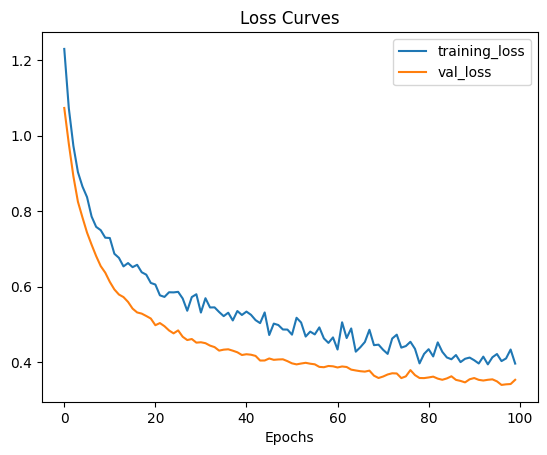

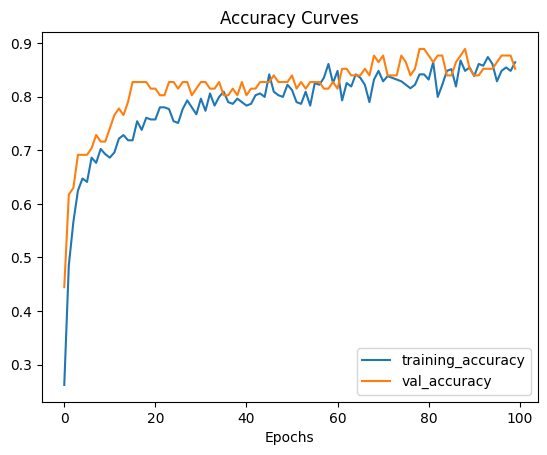

In [34]:
plot_loss_curves(history)

In [35]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        34
           1       0.89      0.77      0.83        31
           2       0.72      0.81      0.76        16

    accuracy                           0.85        81
   macro avg       0.83      0.84      0.84        81
weighted avg       0.86      0.85      0.85        81



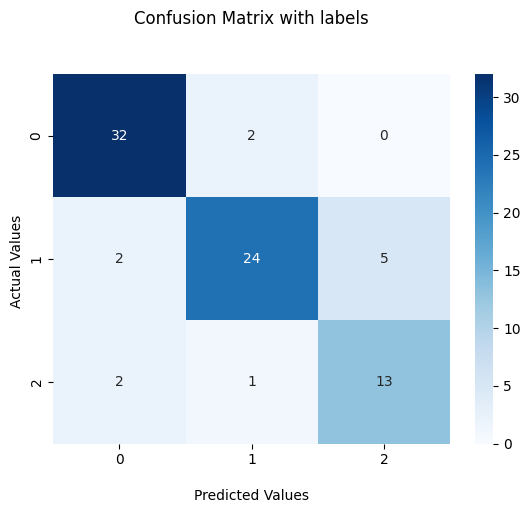

In [36]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [37]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.54      0.70        13
           2       0.40      1.00      0.57         2

    accuracy                           0.73        22
   macro avg       0.70      0.85      0.70        22
weighted avg       0.85      0.73      0.73        22



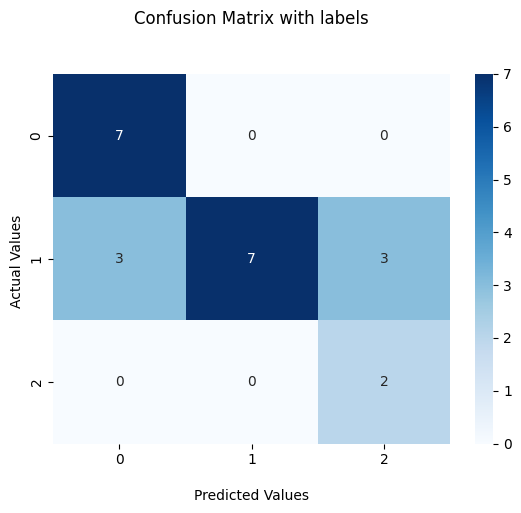

In [38]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [39]:
model.save('my_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: horizontal


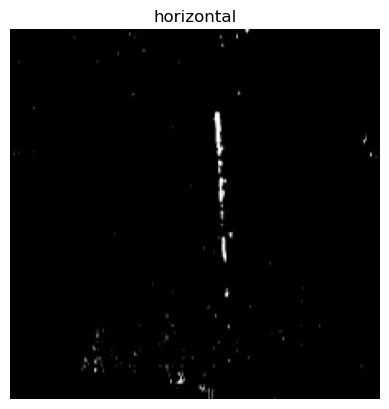

In [12]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\Fabric_defect_detection_system\testing_dataset\verticle\5_processed (3).jpg"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['hole', 'horizontal', 'lines','verticle']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()
